<h1 style="direction:rtl; padding-right:25px">
الگوریتم Forward-Forward
</h1>

<p style="direction:rtl; padding-right:25px">
۴۰۰۴۲۲۱۱۲
<br>
پروژه یادگیری ماشین
</p>

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import random
from HodaDatasetReader import read_hoda_cdb, read_hoda_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import CIFAR10, MNIST
from utils.dataset_utils import TrainingDatasetFF
from utils.models import FFMultiLayerPerceptron, MultiLayerPerceptron
from utils.tools import base_loss, generate_positive_negative_samples_overlay
from torchvision.transforms import Compose, ToTensor, Lambda, Normalize

<p style="direction:rtl; padding-right:25px">
در ابتدا تابع تولید نمونه‌های مثبت و منفی را مشخص می‌کنیم. این تابع، برا تولید نمونه منفی، از یک برچسب غلط تصادفی استفاده می‌کند. همچنین از روشی تحت عنوان overlay برای جاگذاری برچسب استفاده می‌کند. بدین صورت که قسمتی کوچک به طول ۱۰ را از گوشه تصویر برای جاگذاری برچسب به صورت One-Hot کنار می‌گذارد.
</p>

In [2]:
pos_gen_fn = generate_positive_negative_samples_overlay

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

<h3 style="direction:rtl; padding-right:25px">
آماده‌سازی داده‌ها
</h3>

<p style="direction:rtl; padding-right:25px">
در این بخش به آماده‌سازی مجموعه داده مورد استفاده در این مساله می‌پردازیم. این مجموعه که شبیه مجموعه داده MNIST است، از اعداد دست‌نویس فارسی تشکیل شده است و مجموعه داده هدی نام دارد. این مجموعه شامل ۱۰۲ هزار نمونه بوده و اولین بار درسال ۲۰۰۵ در یک پایان‌نامه کارشناسی ارشد معرفی شده است. اطلاعات بیشتر درباره این مجموعه را از <a href="http://farsiocr.ir/%D9%85%D8%AC%D9%85%D9%88%D8%B9%D9%87-%D8%AF%D8%A7%D8%AF%D9%87/%D9%85%D8%AC%D9%85%D9%88%D8%B9%D9%87-%D8%A7%D8%B1%D9%82%D8%A7%D9%85-%D8%AF%D8%B3%D8%AA%D9%86%D9%88%DB%8C%D8%B3-%D9%87%D8%AF%DB%8C/">اینجا</a> بخوانید.
<br>
همانند مقاله الگوریتم Forward-Forward که نتایج آزمایشات خود را بر روی مجموعه داده MNIST گزارش می‌کند، تمامی پیاده‌سازی‌های آن در اینترنت نیز از همین مجموعه استفاده می‌کنند. به منظور ایجاد تمایز و بررسی یک مجموعه جدیدتر و بومی، این الگوریتم را روی مجموعه داده‌ هدی اجرا می‌کنم. لازم به ذکر است که بر خلاف MNIST که به سادگی از طریق بسته torch قابل دسترسی و استفاده است، اکثر مراحل بارگذاری و پیش‌پردازش مجموعه هدی برای torch به صورت دستی صورت گرفته است.
</p>

In [3]:
ax, ay = read_hoda_dataset(
    dataset_path="dataset/Train 60000.cdb",
    images_height=52,
    images_width=52,
    one_hot=True,
    reshape=False,
)

bx, by = read_hoda_dataset(
    dataset_path="dataset/Test 20000.cdb",
    images_height=52,
    images_width=52,
    one_hot=True,
    reshape=False,
)

cx, cy = read_hoda_dataset(
    dataset_path="dataset/RemainingSamples.cdb",
    images_height=52,
    images_width=52,
    one_hot=True,
    reshape=False,
)


In [4]:
X = np.concatenate((ax, bx, cx))
y = np.concatenate((ay, by, cy))
y_label = np.argmax(y, axis=1)
assert len(X) == len(y)
print(f"We have {len(X)} samples in total.")


We have 102352 samples in total.


<p style="direction:rtl; padding-right:25px">
تعداد از نمونه‌های مجموعه داده را در این قسمت مشاهده می‌کنید.
</p>

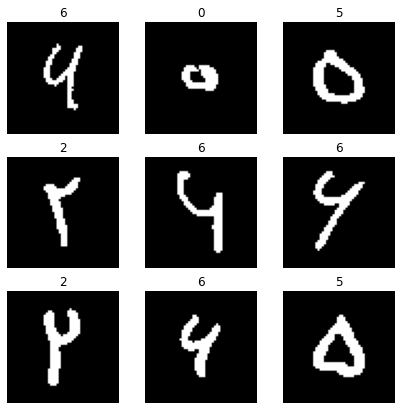

In [5]:
plt.figure(figsize=(7, 7))
smpl = random.sample(range(len(X)), 9)
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.axis("off")
    smpl_idx = smpl[i]
    plt.imshow(X[smpl_idx, :, :, 0], cmap="gray")
    plt.title(np.where(y[smpl_idx] == 1)[0][0])
plt.show()


<p style="direction:rtl; padding-right:25px">
این مجموعه دارای ۱۰ کلاس است. پس از بارگزاری آن، تمامی نمونه‌ها را با هم ادغام کرده، سپس برای حفظ تعادل در کلاس‌ها، از هر کلاس ۱۲٪ داده‌ها را برای test جدا کرده و بقیه را برای train در نظر می‌گیریم.
</p>

In [6]:
for cls in range(10):
    mask = np.where(y_label == cls)[0]
    X_cls = X[mask]
    y_cls = y_label[mask]
    (
        X_cls_train,
        X_cls_test,
        y_cls_train,
        y_cls_test,
    ) = train_test_split(
        X_cls, y_cls, test_size=0.12, random_state=42
    )
    if cls == 0:
        X_train = X_cls_train
        X_test = X_cls_test
        y_train = y_cls_train
        y_test = y_cls_test
        continue
    X_train = np.concatenate((X_train, X_cls_train), axis=0)
    X_test = np.concatenate((X_test, X_cls_test), axis=0)
    y_train = np.concatenate((y_train, y_cls_train), axis=0)
    y_test = np.concatenate((y_test, y_cls_test), axis=0)
print(
    f"train samples: {len(X_train)} | test samples: {len(X_test)}"
)


train samples: 90065 | test samples: 12287


In [7]:
class MyTensorDataset(Dataset):
    """TensorDataset with support of transforms."""

    def __init__(self, tensors, transform=None):
        assert all(
            tensors[0].size(0) == tensor.size(0)
            for tensor in tensors
        )
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


<p style="direction:rtl; padding-right:25px">
در این بخش تصاویر را flatten می‌کنیم، یعنی آن‌ها را از یک ماتریس دوبعدی به یک بردار تبدیل می‌کنیم. باید دقت کنیم که ابعاد تصویر ۵۲ در ۵۲ است، پس بردار حاصل شامل ۲۷۰۴ مقدار بوده و در نتیجه، لایه اول پرسپترون چندلایه ما باید شامل ۲۰۷۴ نورون باشد.
</p>

In [8]:
train_dataset = MyTensorDataset(
    (
        torch.Tensor(X_train),
        torch.Tensor(y_train).type(torch.LongTensor),
    ),
    transform=Lambda(lambda x: torch.flatten(x)),
)
test_dataset = MyTensorDataset(
    (
        torch.Tensor(X_test),
        torch.Tensor(y_test).type(torch.LongTensor),
    ),
    transform=Lambda(lambda x: torch.flatten(x)),
)

In [9]:
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

<p style="direction:rtl; padding-right:25px">
در این بخش یک دیتالودر خاص برای الگوریتم forward-forward می‌سازیم که با هربار فراخوانی، یک نمونه منفی و یک نمونه مثبت به دست می‌دهد.
</p>

In [10]:
def get_loader(dataset, batch_size=1024):
    train_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    train_loader_ff = DataLoader(
        TrainingDatasetFF(
            pos_gen_fn(X.to(device), Y.to(device), False)
            for X, Y in train_loader
        ),
        batch_size=train_loader.batch_size,
        shuffle=True,
    )
    return train_loader_ff

<h3 style="direction:rtl; padding-right:25px">
فرآیند آموزش
</h3>

<p style="direction:rtl; padding-right:25px">
ابتدا چند تابع کمکی تعریف می‌کنم. این کار برای کاهش خطوط کد نوشته شده و به کار گیری دوباره یک ماژول به ازای تنظیمات مختلف و مدل‌های مختلف است.
</p>

In [11]:
def do_train(train_loader, model, epochs):
    for epoch in tqdm(range(epochs)):
        for X_pos, Y_neg in train_loader:
            layer_losses = model.train_batch(
                X_pos, Y_neg, before=False
            )
            print(
                ", ".join(
                    map(
                        lambda i, l: f"Layer {i}: {l}",
                        list(range(len(layer_losses))),
                        layer_losses,
                    )
                ),
                end="\r",
            )


In [12]:
def do_test(test_dataloader, model):
    accuracy = 0
    counter = 0
    for X_test, Y_test in tqdm(test_dataloader, total=len(test_dataloader)):
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)

        accuracy += (
            model.predict_accomulate_goodness(
                X_test, pos_gen_fn, n_class=10
            )
            .eq(Y_test)
            .sum()
        )
        counter += len(X_test)

    print(f"Accuracy on test set: {accuracy/counter:.4%}")
    # print(f"Test error: {1 - accuracy/counter:.4%}")

<h4 style="direction:rtl; padding-right:25px">
آموزش و ارزیابی شبکه به روش Forward-Forward
</h4>

<p style="direction:rtl; padding-right:25px">
ابتدا یک شبکه به همراه دیتالودر تعریف کرده و کل لایه‌های آن را برای ۶۰ گام آموزش می‌دهیم.
</p>

In [13]:
train_loader_ff = get_loader(train_dataset, batch_size=1024)

In [14]:
mlp_model = FFMultiLayerPerceptron(
    hidden_dimensions=[2704, 512, 512],
    activation=torch.nn.ReLU(),
    optimizer=torch.optim.Adam,
    layer_optim_learning_rate=0.09,
    threshold=9.0,
    loss_fn=base_loss,
).to(device)

In [15]:
do_train(train_loader_ff, mlp_model, 60)

  0%|          | 0/60 [00:00<?, ?it/s]

In [16]:
do_test(test_loader, mlp_model)

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on test set: 97.8107%


<p style="direction:rtl; padding-right:25px">
حال مدل را برای گام‌های بیشتری آموزش می‌دهیم. به نظر می‌رسد اینکار تاثیری مثبتی بر دقت تست ندارد.
باید دقت داشت که به منظور مقایسه عادلانه، قبل از آموزش مدل با تنظیمات متفاوت و جدید باید پارامتر‌های آن را ریست کرد تا بهینه‌سازی را دوباره از وزن‌های تصادفی شروع کنیم، نه وزن‌هایی که قبلا مدل یاد گرفته است.
</p>

In [18]:
for layer in mlp_model.layers:
    layer.reset_parameters()
do_train(train_loader_ff, mlp_model, 200)

  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
do_test(test_loader, mlp_model)

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on test set: 97.0945%


In [33]:
mlp_model2 = FFMultiLayerPerceptron(
    hidden_dimensions=[2704, 1024, 1024],
    activation=torch.nn.ReLU(),
    optimizer=torch.optim.Adam,
    layer_optim_learning_rate=0.09,
    threshold=9.0,
    loss_fn=base_loss,
).to(device)

In [34]:
do_train(train_loader_ff, mlp_model2, 60)

  0%|          | 0/60 [00:00<?, ?it/s]

In [35]:
do_test(test_loader, mlp_model)

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on test set: 97.9735%


<p style="direction:rtl; padding-right:25px;">
حال در هر لحظه، یک لایه را آموزش می‌دهیم. این کار به نظر تاثیر مثبتی بر دقت تست دارد و باعث افزایش آن می‌شود، بدون این که مدل را پیچیده‌تر کرده باشیم.
</p>

In [15]:
for layer in mlp_model.layers:
    layer.reset_parameters()
mlp_model.train_batch_progressive(60, train_loader_ff)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 60/60, Layer 0: 0.28755465149879456

Epoch: 60/60, Layer 1: 0.33019915223121643



In [16]:
do_test(test_loader, mlp_model)

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on test set: 97.9735%


<h4 style="direction:rtl; padding-right:25px">
آموزش و ارزیابی شبکه با پس‌انتشار خطا
</h4>

<p style="direction:rtl; padding-right:25px">
در این بخش، آموزش را با روش پس‌انتشار خطا یا backpropagation انجام می‌دهیم. ابتدا توابع کمکی و دیتالودر را تعریف می‌کنیم.
</p>

In [17]:
train_loader = DataLoader(
    train_dataset, batch_size=1024, shuffle=True
)

In [26]:
loss_fn = torch.nn.CrossEntropyLoss()
n_epochs = 20

In [27]:
mlp_backprop_model = MultiLayerPerceptron(
    hidden_dimensions=[2704, 512, 512, 10],
    activation=torch.nn.ReLU(),
).to(device)
optimizer = torch.optim.Adam(mlp_backprop_model.parameters())

In [28]:
for epoch in tqdm(range(n_epochs)):
    for i, (X_train, Y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        Y_train = Y_train.to(device)

        Y_pred = mlp_backprop_model(X_train)

        loss = loss_fn(Y_pred, Y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss}", end="\r")


  0%|          | 0/20 [00:00<?, ?it/s]

In [32]:
accuracy = 0
counter = 0

for X_test, Y_test in tqdm(test_loader, total=len(test_loader)):
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    counter += len(X_test)
    accuracy += (
        torch.softmax(mlp_backprop_model(X_test), 1)
        .argmax(1)
        .eq(Y_test)
        .sum()
    )

print(f"Accuracy: {accuracy/counter:.4%}")
print(f"Test error: {1 - accuracy/counter:.4%}")


  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy: 98.7141%
Test error: 1.2859%


<p style="direction:rtl; padding-right:25px">
همانطور که مشخص است، آموزش مدل با پس‌انتشار خطا، در گام‌های کمتر به خطای بسیار کوچکتری روی داده‌های آموزشی می‌رسد، همچنین دقت تست بیشتری نیز دارد. در نتیجه به نظر بعید است که الگوریتم forward-forward در کارکردهای معمولی جایگزین پس‌انتشار خطا شود.
</p>